In [97]:
import scipy.io, math, os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from utils import *
from nltk.corpus import cmudict
from numpy import linalg as LA
import seaborn as sns
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import Levenshtein
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation

In [2]:
subjects = ['F1', 'F5', 'M1', 'M3']
subj_index = 0

def get_srate(file_number):
    directory = 'data/Data/{}/mat'.format(subjects[subj_index])
    
    # TODO: needs to ignore the .DS_Store file in a better way
    files = sorted(os.listdir(directory))
    try:
        files.remove('.DS_Store')
    except:
        pass
    
    file = files[file_number]
    
    f = os.path.join(directory, file)
    mat = scipy.io.loadmat(f)['usctimit_ema_{}_{:03}_{:03}'.format(subjects[subj_index].lower(), file_number*5 + 1, file_number*5 + 5)]
    
    #returns the srate which is awkwardly stored here
    return mat[0][1][1][0][0]

In [3]:
# can't put this in the utils file 
d = cmudict.dict()
def nsyl(word):
    try:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    except KeyError:
        #if word not found in cmudict
        return syllables(word)

In [4]:
def get_pos_list(position, dimension, file_number, starting_point, end_point):
    values = []
    if dimension == 'x':
        dim = 0
    elif dimension == 'y':
        dim = 1 
    elif dimension == 'z':
        dim = 2
    else:
        raise ValueError

    positions = ['UL', 'LL', 'JW', 'TB', 'TD', 'TT']
    dataframes = [UL_df, LL_df, JW_df, TB_df, TD_df, TT_df]
    index = positions.index(position)
    
    for i in range(end_point - starting_point):
        coordinate = (dataframes[index][file_number][dim][starting_point + i])
        if str(coordinate) != 'nan':
            values.append(coordinate)
            
    return np.array(values)

In [5]:
directory = 'data/Data/{}/mat'.format(subjects[subj_index])
counter = 1
UL_df, LL_df, JW_df, TD_df, TB_df, TT_df = [], [], [], [], [], []

for filename in sorted(os.listdir(directory)):
    if filename.endswith('.mat'):
        f = os.path.join(directory, filename)
        mat = scipy.io.loadmat(f)
        # takes the data that is stored at the key that precedes the data for each .mat file
        data = mat['usctimit_ema_{}_{:03}_{:03}'.format(subjects[subj_index].lower(), counter, counter + 4)]
        counter += 5

        # make dataframes of the six positions
        UL_df.append(pd.DataFrame.from_dict(data[0][1][2]))
        LL_df.append(pd.DataFrame.from_dict(data[0][2][2]))
        JW_df.append(pd.DataFrame.from_dict(data[0][3][2]))
        TD_df.append(pd.DataFrame.from_dict(data[0][4][2]))
        TB_df.append(pd.DataFrame.from_dict(data[0][5][2]))
        TT_df.append(pd.DataFrame.from_dict(data[0][6][2]))

In [6]:
frames = {}
sensors = ['ULx', 'ULy', 'LLx', 'LLy', 
           'JWx', 'JWy', 'TDx', 'TDy', 
           'TBx', 'TBy', 'TTx', 'TTy']

with open('timestamps.txt', 'r') as file:
    timestamps = file.read().splitlines()
    for word_number, line in enumerate(timestamps):
        split_line = line.split(',')
        sent_number = int(split_line[-1])
        
        # find start and end by multiplying the timestamps with the sampling rate
        starting_point = math.floor(float(split_line[2]) * get_srate(int(split_line[0])))
        end_point = math.ceil(float(split_line[3]) * get_srate(int(split_line[0])))
        
        # make new dataframe for the current word
        df = pd.DataFrame()
        
        for sensor in sensors:
            # position, dimension, file_number, starting_point, end_point
            array = get_pos_list(sensor[:2], sensor[-1], int(split_line[0]), starting_point, end_point)
            df[sensor] = pd.Series(array)
            df.word = split_line[1]
            df.sent = int(split_line[-1])
            df.syl = nsyl(split_line[1])
            frames[word_number] = df

/var/folders/jz/414l_qjs6s1bndtz3ppcy8cc0000gn/T/ipykernel_27158/3300215939.py:25: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.syl = nsyl(split_line[1])


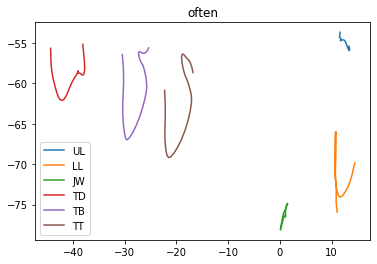

In [7]:
word_instances = [i.split(',')[1] for i in timestamps]

word = 'often'
word_inds = [i for i, x in enumerate(word_instances) if x == word]
word_ind = word_inds[0]

def make_trajectory_plot(df_word_sensors, word):
    "df_word_sensors: df per word Nx12, N is time, 12 sensors"
    fig, ax = plt.subplots(1, 1)
    x = df_word_sensors
    for i_sen, s in enumerate(['UL', 'LL', 'JW', 'TD', 'TB', 'TT']):
        ax.plot(x[s + 'x'], x[s + 'y'], label=s)

    plt.legend(['UL', 'LL', 'JW', 'TD', 'TB', 'TT'], loc='lower left')
    ax.set_title(word)

make_trajectory_plot(frames[word_ind], word)

In [8]:
do_normalize = True

syl1_words, syl2_words, syl3_words = {}, {}, {}
syl4_words, syl5_words, syl6_words = {}, {}, {}

syl_frames = [syl1_words, syl2_words, 
              syl3_words, syl4_words, 
              syl5_words, syl6_words]

scaler = StandardScaler()
scaler.fit(pd.concat(frames))

for i in range(1, len(syl_frames) + 1):
    for count, frame in enumerate(frames):
        # for some reason some words store the number of syllables in an array, hence the try except
        if (isinstance(frames[frame].syl, list) and frames[frame].syl[0] == i) or\
            (not isinstance(frames[frame].syl, list) and frames[frame].syl == i):
            # standardize the data to have a mean of 0 and approx. a SD of 1
            if do_normalize:
                # scaler.fit(frames[frame])
                # data = scaler.transform(frames[frame])
                data = scaler.transform(frames[frame])
                df = pd.DataFrame(data, columns=sensors)

                # set meta-data, at this point we only need the word and the sentence it came from
                df.word = frames[frame].word
                df.sent = frames[frame].sent

                syl_frames[i - 1][count] = df
            else:
                syl_frames[i - 1][count] = frames[frame]

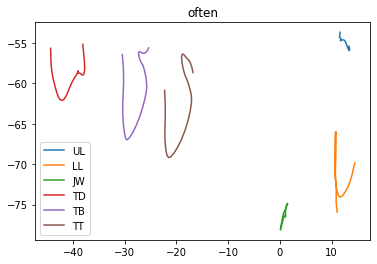

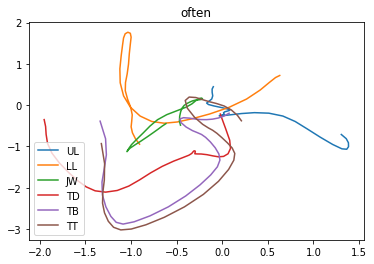

In [9]:
make_trajectory_plot(frames[word_ind], word)
make_trajectory_plot(syl_frames[1][word_ind], word)

In [10]:
for i, frame in enumerate(syl_frames):
    if i < 0:
        continue
    else:
        # target length is the the word with the most samples in that syllable category
        target_length = longest_frame(frame)
        for word in frame.keys():
            current_length = frame[word].shape[0]
            pad_length1 = int((target_length - current_length) / 2)
            if np.mod((target_length - current_length),2) == 1:
                pad_length2 = pad_length1 + 1
            else:
                pad_length2 = pad_length1

            frame[word] = pd.DataFrame(np.pad(frame[word].values, ((pad_length1,pad_length2), (0,0)), 'mean'),
                                       columns=sensors).transpose()

In [11]:
difference_matrix_1, difference_matrix_2, difference_matrix_3 = [], [], []
difference_matrix_4, difference_matrix_5, difference_matrix_6 = [], [], []

difference_matrices = [difference_matrix_1, difference_matrix_2, 
                       difference_matrix_3, difference_matrix_4, 
                       difference_matrix_5, difference_matrix_6]

for i, matrix in enumerate(syl_frames):
    if i < 0:
        continue
    else:
        for row_word in matrix.values():
            row = np.array([])
            for column_word in matrix.values():
                difference_matrix = row_word.subtract(column_word).to_numpy()
                frob_norm = linalg.norm(difference_matrix)

                row = np.append(row, frob_norm)

            difference_matrices[i].append(row)

In [81]:
syl5 = []
for frame in syl5_words:
    syl5.append(frame)
    
labels = []
for i in syl5:
    labels.append(frames[i].word)

In [82]:
diff5 = np.array([difference_matrix_5])
df = pd.DataFrame(diff5[0])
df.columns, df.index = labels, labels

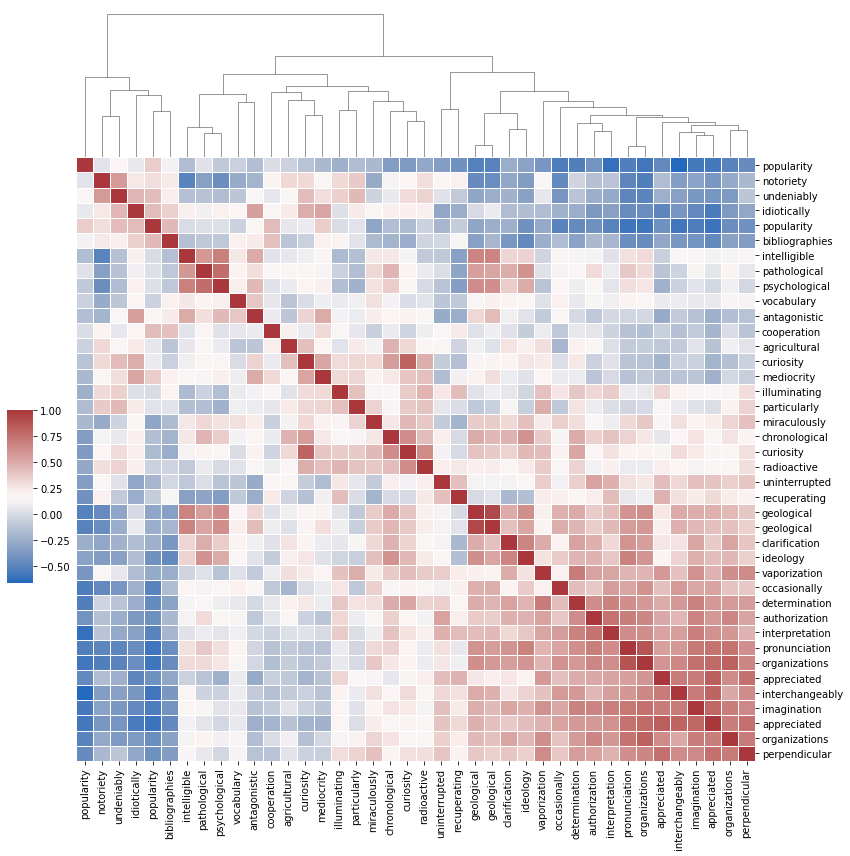

In [84]:
correlations = df.corr()
correlations_array = np.asarray(df.corr())

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

clustermap = sns.clustermap(correlations, row_linkage=row_linkage, 
                            dendrogram_ratio=(.1, .2),
                            method="average",
                            cbar_pos=(.02, .32, .03, .2),
                            figsize=(12, 12), linewidths=1, 
                            cmap='vlag')

clustermap.ax_row_dendrogram.remove()

# all clustermaps can be found in the 'cluster results' folder
# plt.savefig('{}_global_norm.png'.format(subjects[subj_index]))

In [105]:
X = row_linkage

# make clusters with hierarchical clustering 
# TODO: find the best value for t
syl5_hierarchical_clusters = {}
hierarchical_clusters = hierarchy.fcluster(row_linkage, t=1)
zipped = tuple(zip(hierarchical_clusters, labels))
for pair in zipped:
    if pair[0] in syl5_hierarchical_clusters:
        syl5_hierarchical_clusters[pair[0]].append(pair[1])
    else:
        syl5_hierarchical_clusters[pair[0]] = [pair[1]]

# make clusters with kmeans clustering 
syl5_kmeans_clusters = {}
clustering = AgglomerativeClustering(n_clusters=10).fit(X)
kmeans_clusters = clustering.labels_
zipped = tuple(zip(kmeans_clusters, labels))
for pair in zipped:
    if pair[0] in syl5_kmeans_clusters:
        syl5_kmeans_clusters[pair[0]].append(pair[1])
    else:
        syl5_kmeans_clusters[pair[0]] = [pair[1]]

# make clusters with affinity propagation
syl5_AP_clusters = {}
clustering = AffinityPropagation(random_state=5).fit(X)
AP_clusters = clustering.labels_
centers = clustering.cluster_centers_
zipped = tuple(zip(AP_clusters, labels))
for pair in zipped:
    if pair[0] in syl5_AP_clusters:
        syl5_AP_clusters[pair[0]].append(pair[1])
    else:
        syl5_AP_clusters[pair[0]] = [pair[1]]

In [100]:
# test if the current subject has any words with missing values 
temp = []

for frame in frames:
    if frames[frame].isnull().values.any():
        temp.append(frame)
            
hoi = sorted(temp)
print(hoi)

[]
